In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
data = pd.read_csv('../data/MXvideos_cc50_202101.csv')

In [3]:
data_limpia = data.drop_duplicates()
data_limpia = data_limpia.drop_duplicates(subset='video_id')

In [4]:
#Verificar datos faltantes
def imprimir_nulos(df):
    total = len(df)
    for col in df.columns:
        nulos = df[col].isnull().sum()
        if nulos > 0:
            porcentaje = round((nulos / total) * 100, 2)
            print(f"La columna '{col}' tiene {nulos} datos vacíos, representan un {porcentaje}% de los registros")

print("Reporte de valores nulos tras eliminar duplicados:\n")
imprimir_nulos(data_limpia)

Reporte de valores nulos tras eliminar duplicados:

La columna 'video_id' tiene 1 datos vacíos, representan un 0.0% de los registros
La columna 'trending_date' tiene 665 datos vacíos, representan un 1.94% de los registros
La columna 'title' tiene 701 datos vacíos, representan un 2.05% de los registros
La columna 'channel_title' tiene 710 datos vacíos, representan un 2.07% de los registros
La columna 'category_id' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'publish_time' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'tags' tiene 725 datos vacíos, representan un 2.12% de los registros
La columna 'views' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'likes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'dislikes' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'comment_count' tiene 738 datos vacíos, representan un 2.15% de los registros
La columna 'thumbn

In [5]:
#Eliminar datos críticos que representan una minoría del dataset
total = len(data_limpia)
columnas_criticas = [
    'video_id', 'trending_date', 'title', 'channel_title', 'category_id',
    'publish_time', 'tags', 'views', 'likes', 'dislikes'
]

for col in columnas_criticas:
    nulos = data_limpia[col].isnull().sum()
    porcentaje = nulos / total
    if porcentaje <= 0.10 and nulos > 0:
        print(f"Eliminando {nulos} registros con nulos en columna crítica: {col} ({round(porcentaje*100,2)}%)")
        data_limpia = data_limpia[data_limpia[col].notnull()]

print("\nValores nulos restantes después de limpieza final:")
imprimir_nulos(data_limpia)

Eliminando 1 registros con nulos en columna crítica: video_id (0.0%)
Eliminando 664 registros con nulos en columna crítica: trending_date (1.94%)
Eliminando 36 registros con nulos en columna crítica: title (0.11%)
Eliminando 9 registros con nulos en columna crítica: channel_title (0.03%)
Eliminando 28 registros con nulos en columna crítica: category_id (0.08%)

Valores nulos restantes después de limpieza final:
La columna 'description' tiene 3627 datos vacíos, representan un 10.82% de los registros


In [6]:
#Imputar una descripción simbólica a aquellos registros sin descripción
def rellenar_descripcion(df):
    if 'description' in df.columns:
        df['description'] = df['description'].fillna("Sin descripción")
    return df

data_limpia = rellenar_descripcion(data_limpia)
imprimir_nulos(data_limpia)

In [7]:
columnas = ['views', 'likes', 'dislikes', 'comment_count']

for col in columnas:
    Q1 = data_limpia[col].quantile(0.25)
    Q3 = data_limpia[col].quantile(0.75)
    minimo = data_limpia[col].min()
    maximo = data_limpia[col].max()
    print(f"{col} → Min: {minimo:.2f}, Q1: {Q1:.2f}, Q3: {Q3:.2f}, Max: {maximo:.2f}")

views → Min: 157.00, Q1: 13805.00, Q3: 137410.00, Max: 39349928.00
likes → Min: 0.00, Q1: 248.00, Q3: 4984.00, Max: 3880211.00
dislikes → Min: 0.00, Q1: 14.00, Q3: 171.00, Max: 483969.00
comment_count → Min: 0.00, Q1: 33.00, Q3: 632.00, Max: 692356.00


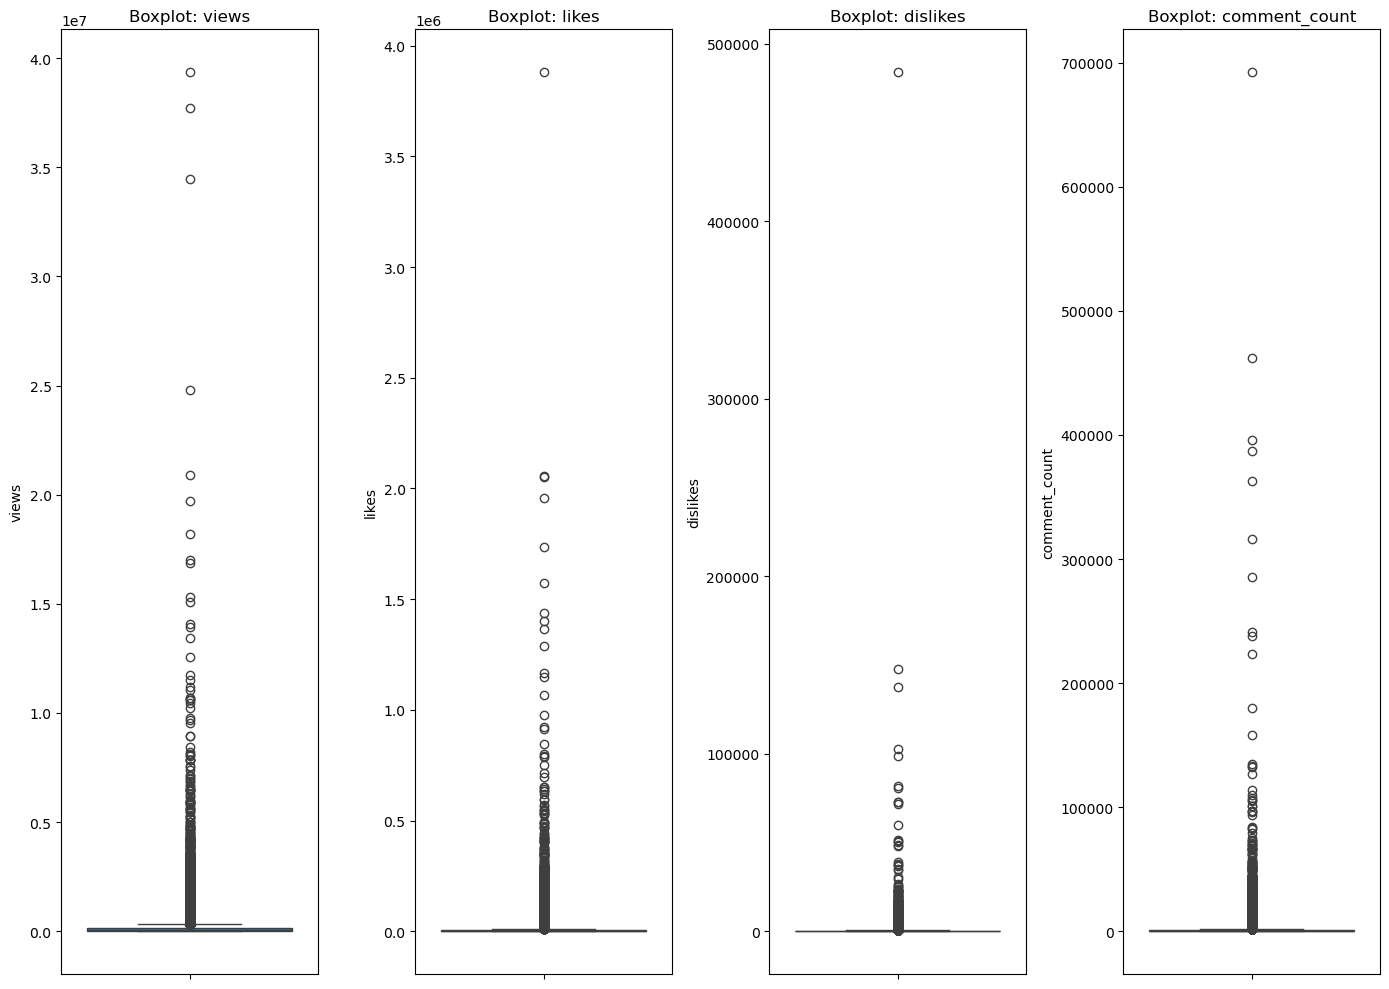

In [8]:
# Boxplots para identificar outliers en columnas numéricas
plt.figure(figsize=(14, 10))
for i, col in enumerate(['views', 'likes', 'dislikes', 'comment_count']):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=data_limpia[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

#📌 Winsorización
Se aplicó la winsorización al 1% y 99% para reducir la influencia de valores extremos sin eliminar registros. Esta técnica conserva la integridad del dataset y estabiliza medidas como la media y la varianza, especialmente en variables con datos altamente virales como views y likes.

#📌 Transformación logarítmica
Se utilizó la transformación logarítmica (log(x + 1)) para comprimir la escala de las variables numéricas y mejorar su interpretabilidad. Esto facilita comparaciones proporcionales, análisis de tendencias y modelos predictivos, al suavizar distribuciones sesgadas.

| Nº | Pregunta                                                                             | ¿Usar log? | Justificación                                                                      |
| -- | ------------------------------------------------------------------------------------ | ---------- | ---------------------------------------------------------------------------------- |
| 1  | ¿Qué categorías de videos son las de mayor tendencia?                                | ❌          | Puedes usar conteo de videos o views directos (sin log).                           |
| 2  | ¿Qué categorías de videos son los que más gustan? ¿Y las que menos gustan?           | ✅          | El log evita que unos pocos videos con millones de likes dominen el promedio.      |
| 3  | ¿Qué categorías tienen mejor ratio “Me gusta” / “No me gusta”?                       | ✅          | El uso de `log(likes+1)/log(dislikes+1)` estabiliza proporciones sesgadas.         |
| 4  | ¿Qué categorías tienen mejor ratio “Vistas” / “Comentarios”?                         | ✅          | El log ayuda a interpretar mejor la interacción media, evitando valores extremos.  |
| 5  | ¿Cómo ha cambiado el volumen de videos en tendencia a lo largo del tiempo?           | ❌          | Puedes usar conteo directo por fecha o categoría.                                  |
| 6  | ¿Qué Canales son tendencia más frecuentemente? ¿Y cuáles con menos frecuencia?       | ❌          | Aquí se usa frecuencia (conteo), no valores numéricos extremos.                    |
| 7  | ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”? | ✅          | Sumar con log reduce distorsión por 1 solo video viral por estado.                 |
| 8  | ¿Los videos en tendencia son los que más comentarios positivos reciben?              | ✅          | El log ayuda a analizar correlaciones más suaves con `comment_count`.              |
| 9  | ¿Es factible predecir el número de “Vistas”, “Me gusta” o “No me gusta”?             | ✅          | La regresión funciona mejor con variables transformadas para estabilizar varianza. |


In [9]:
# 1. Aplicar winsorización al 1% y 99%
def winsorizar(df, columnas, limite_inferior=0.01, limite_superior=0.99):
    for col in columnas:
        p_inf = df[col].quantile(limite_inferior)
        p_sup = df[col].quantile(limite_superior)
        df[col] = df[col].clip(lower=p_inf, upper=p_sup)
        print(f"--> Winsorización aplicada a '{col}' entre P1={p_inf:.2f} y P99={p_sup:.2f}")
    return df

columnas_numericas = ['views', 'likes', 'dislikes', 'comment_count']
data_limpia = winsorizar(data_limpia, columnas_numericas)

# 2. Aplicar transformación logarítmica (log1p = log(x+1))
for col in columnas_numericas:
    data_limpia[f'{col}_log'] = np.log1p(data_limpia[col])
    print(f"=> Transformación logarítmica aplicada a '{col}' → '{col}_log'")

data_limpia[[f'{col}_log' for col in columnas_numericas]].describe()

--> Winsorización aplicada a 'views' entre P1=2100.24 y P99=2322629.64
--> Winsorización aplicada a 'likes' entre P1=0.00 y P99=139016.72
--> Winsorización aplicada a 'dislikes' entre P1=0.00 y P99=4821.76
--> Winsorización aplicada a 'comment_count' entre P1=0.00 y P99=20643.64
=> Transformación logarítmica aplicada a 'views' → 'views_log'
=> Transformación logarítmica aplicada a 'likes' → 'likes_log'
=> Transformación logarítmica aplicada a 'dislikes' → 'dislikes_log'
=> Transformación logarítmica aplicada a 'comment_count' → 'comment_count_log'


,views_log,likes_log,dislikes_log,comment_count_log
count,33513.000000,33513.000000,33513.000000,33513.000000
mean,10.732152,6.952142,3.940854,4.973980
std,1.584120,2.223292,1.800233,2.131632
min,7.650283,0.000000,0.000000,0.000000
25%,9.532859,5.517453,2.708050,3.526361
50%,10.637537,6.880384,3.850148,5.023881
75%,11.830732,8.514189,5.147494,6.450470
max,14.658211,11.842357,8.481102,9.935211


4. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” /
“Comentarios”?

In [10]:
# Calcular ratio
data_limpia = data_limpia[data_limpia['comment_count'] > 0]
data_limpia['views_per_comment'] = data_limpia['views'] / data_limpia['comment_count']

# Agrupar por categoría
top_categorias = data_limpia.groupby('category_name')['views_per_comment'].mean().dropna().sort_values(ascending=False).head(10)

# Graficar con etiquetas
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_categorias.values, y=top_categorias.index, palette="viridis")
plt.title("Top 10 Categorías con Mayor Ratio de Vistas por Comentario")
plt.xlabel("Ratio Vistas/Comentario")
plt.ylabel("Categoría")

# Añadir etiquetas numéricas
for i, valor in enumerate(top_categorias.values):
    ax.text(valor + 30, i, f"{valor:.0f}", va='center')

plt.tight_layout()
plt.show()


KeyError: 'category_name'

### Conclusión:

El análisis muestra que las categorías **"Sports"** y **"Travel & Events"** presentan el ratio más alto de vistas por comentario, lo que indica un gran alcance y visualización con relativamente baja participación en comentarios.  
Por otro lado, categorías como **"Education"** o **"Science & Technology"** tienen ratios más bajos, lo que sugiere una audiencia más participativa en comentarios en proporción al número de vistas.

---

### Recomendación para el negocio:

- Si el objetivo es **maximizar el alcance y visibilidad**, se recomienda enfocar la producción de contenido en categorías como **"Sports"** y **"Travel & Events"**, ya que permiten llegar a más personas por cada comentario recibido.

- Si la prioridad es **generar conversación o engagement profundo**, se sugiere apostar por categorías como **"Education"** o **"Science & Technology"**, donde los usuarios tienden a interactuar más activamente.

- Se recomienda además realizar pruebas A/B para comparar el rendimiento en función de los objetivos clave del negocio (branding, tráfico, conversiones, etc.).


5. ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\3322915393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_limpia['trending_date'] = pd.to_datetime(data_limpia['trending_date'], format='%y.%d.%m', errors='coerce')


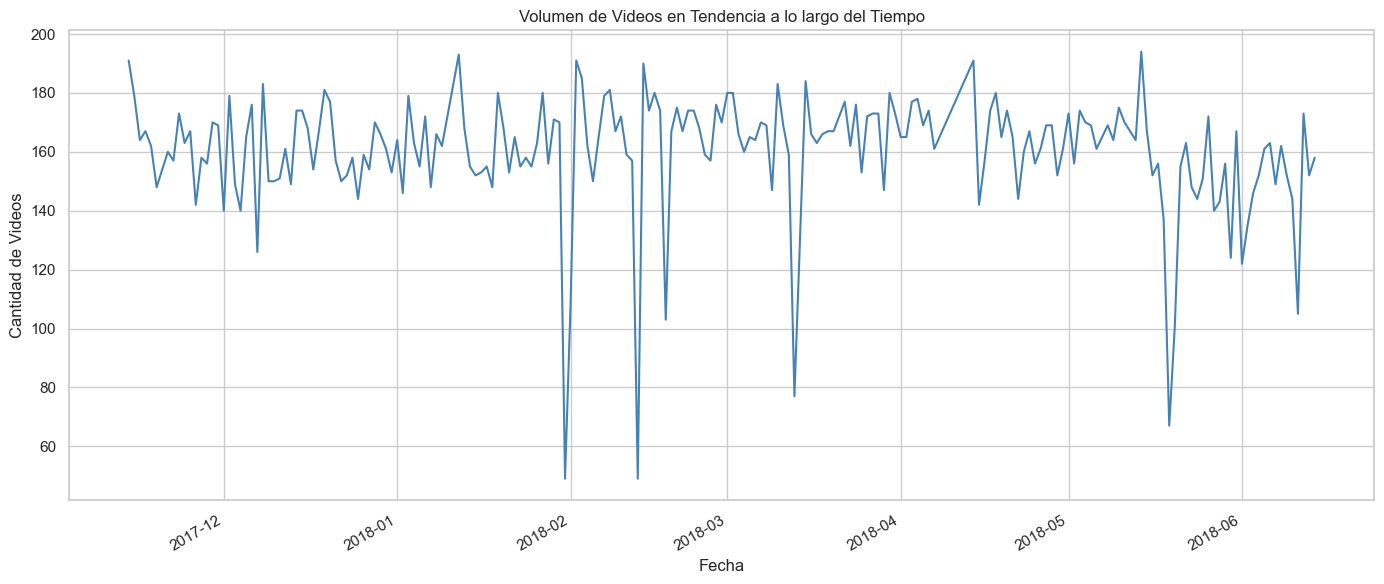

In [ ]:
# Convertir trending_date si no se hizo antes
data_limpia['trending_date'] = pd.to_datetime(data_limpia['trending_date'], format='%y.%d.%m', errors='coerce')

# Agrupar y graficar
volumen_tiempo = data_limpia.groupby('trending_date').size()

plt.figure(figsize=(14, 6))
volumen_tiempo.plot(kind='line', color='steelblue')
plt.title("Volumen de Videos en Tendencia a lo largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Videos")
plt.tight_layout()
plt.show()


### Conclusión:

El análisis del volumen de videos en tendencia muestra que, en general, **se mantiene una alta constancia diaria** de publicaciones, con un promedio de entre **140 y 180 videos por día**.  
Sin embargo, se observan **caídas bruscas** en la cantidad de videos en ciertas fechas, principalmente en los meses de:

- **Febrero 2018**  
- **Marzo 2018**  
- **Mayo y junio 2018**

Estas caídas pueden deberse a **problemas de recolección de datos, cambios en el algoritmo de tendencias de YouTube** o incluso a **eventos particulares como feriados o actualizaciones del sistema**.

---

### Recomendación para el negocio:

- Evitar realizar comparaciones directas de métricas en días donde el volumen total de videos fue **anormalmente bajo**, ya que podrían distorsionar los análisis.

- Para lograr mayor visibilidad, se sugiere **lanzar contenido en los días de mayor actividad (alta cantidad de videos en tendencia)**, ya que estos reflejan **una mayor audiencia activa**.

- Sería beneficioso para la empresa implementar una rutina de análisis que **detecte anomalías temporales** y las marque, para **excluirlas de modelos predictivos o de comportamiento**.


6. ¿Qué Canales de YouTube son tendencia más frecuentemente? ¿Y cuáles con menos
frecuencia?

C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\1201276803.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_canales.values, y=top_canales.index, palette="magma")


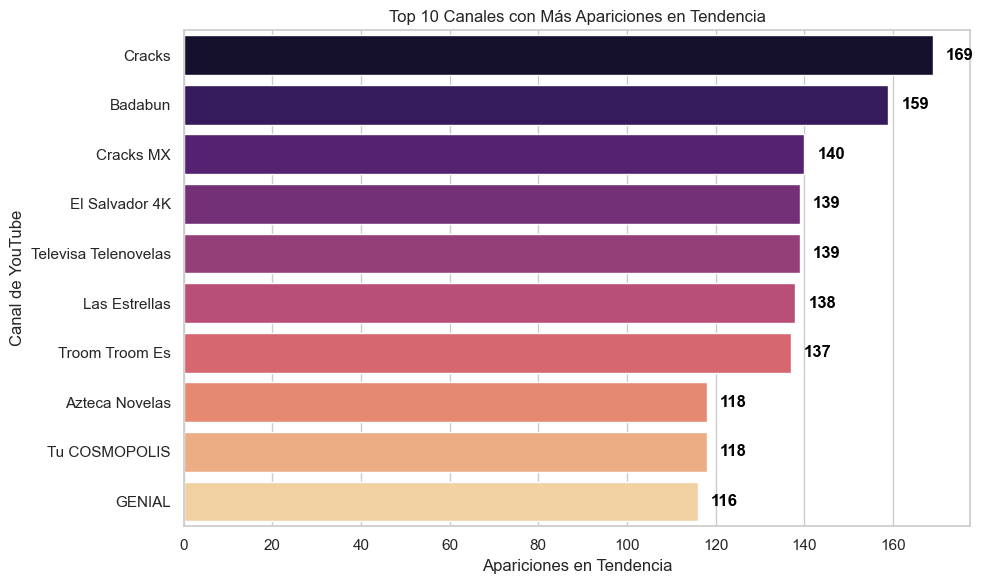

In [ ]:
# Top 10 canales con más apariciones
top_canales = data_limpia['channel_title'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_canales.values, y=top_canales.index, palette="magma")
plt.title("Top 10 Canales con Más Apariciones en Tendencia")
plt.xlabel("Apariciones en Tendencia")
plt.ylabel("Canal de YouTube")

# Mostrar los valores al costado de cada barra
for i, value in enumerate(top_canales.values):
    ax.text(value + 3, i, str(value), va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_31372\807480715.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='apariciones', y='channel_title', data=df_canales_muestra, palette='cubehelix')


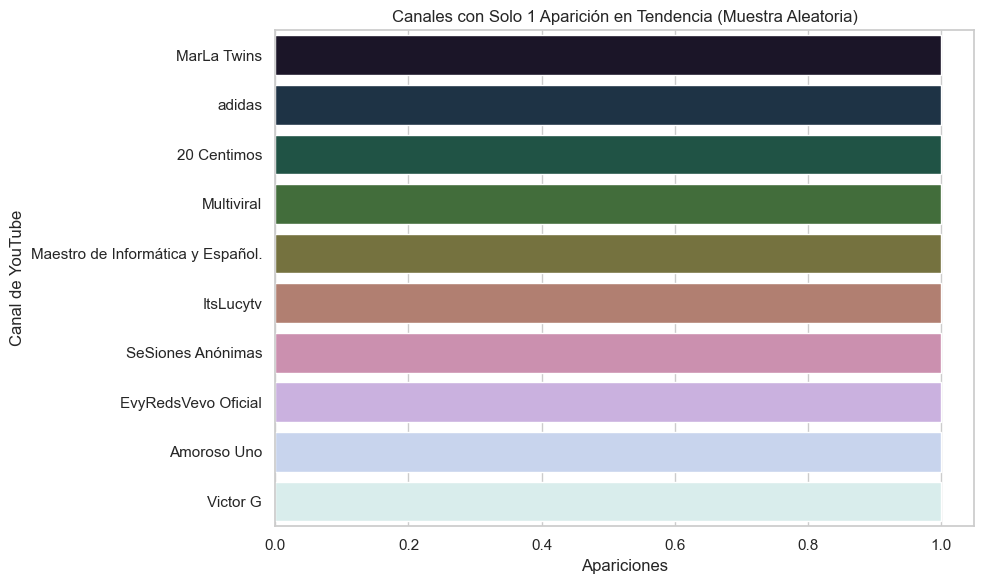

In [ ]:
# Canales con solo 1 aparición
canales_frecuencia = data_limpia['channel_title'].value_counts()
canales_una_aparicion = canales_frecuencia[canales_frecuencia == 1]

# Tomar muestra de 10 (puedes cambiar el número)
canales_muestra = canales_una_aparicion.sample(10, random_state=42)

# Convertir a DataFrame para graficar
df_canales_muestra = canales_muestra.reset_index()
df_canales_muestra.columns = ['channel_title', 'apariciones']

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='apariciones', y='channel_title', data=df_canales_muestra, palette='cubehelix')
plt.title("Canales con Solo 1 Aparición en Tendencia (Muestra Aleatoria)")
plt.xlabel("Apariciones")
plt.ylabel("Canal de YouTube")
plt.tight_layout()
plt.show()


### Análisis de Apariciones en Tendencia por Canal

#### Conclusión
El gráfico de los **Top 10 canales** revela que ciertos creadores, como **Cracks**, **Badabun** y **Cracks MX**, dominaron las tendencias con más de 140 apariciones cada uno. Esto sugiere una fuerte presencia en la plataforma y un contenido recurrentemente popular o viral. En contraste, el segundo gráfico muestra una muestra de canales con **solo una aparición** en tendencia, lo cual refleja una gran dispersión en el ecosistema de creadores, donde muchos apenas logran alcanzar visibilidad.

#### Recomendación al negocio
Se recomienda a la empresa cliente analizar los patrones de contenido, horarios de publicación y temáticas de los canales con más apariciones para **identificar factores de éxito replicables**. Además, sería valioso diseñar estrategias de colaboración con canales emergentes (de baja aparición) que tengan potencial, con el fin de diversificar el contenido y captar nuevas audiencias.


7. ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”?

In [12]:
data_limpia['state'] = data_limpia['state'].str.upper()

# Agrupar likes por estado y calcular coordenadas promedio
interacciones_estado = data_limpia.groupby('state').agg({
    'views': 'sum',
    'likes': 'sum',
    'dislikes': 'sum',
    'lat': 'mean',
    'lon': 'mean'
}).reset_index()

# Crear el mapa
fig_likes = px.scatter_geo(
    interacciones_estado,
    lat='lat',
    lon='lon',
    text='state',
    color='likes',
    size='likes',
    color_continuous_scale='plasma',
    labels={'likes': 'Likes'},
    title='México - Likes en Videos de YouTube por Estado'
)

fig_likes.update_geos(scope='north america', lataxis_range=[14, 33], lonaxis_range=[-118, -86])
fig_likes.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_likes.show()

In [13]:
# Mapa de Vistas
fig_views = px.scatter_geo(
    interacciones_estado,
    lat='lat',
    lon='lon',
    text='state',
    color='views',
    size='views',
    color_continuous_scale='viridis',
    labels={'views': 'Vistas'},
    title='México - Vistas en Videos de YouTube por Estado'
)
fig_views.update_geos(scope='north america', lataxis_range=[14, 33], lonaxis_range=[-118, -86])
fig_views.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_views.show()

In [14]:
# Mapa de No me gusta
fig_dislikes = px.scatter_geo(
    interacciones_estado,
    lat='lat',
    lon='lon',
    text='state',
    color='dislikes',
    size='dislikes',
    color_continuous_scale='reds',
    labels={'dislikes': 'No me gusta'},
    title='México - No me gusta en Videos de YouTube por Estado'
)
fig_dislikes.update_geos(scope='north america', lataxis_range=[14, 33], lonaxis_range=[-118, -86])
fig_dislikes.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig_dislikes.show()

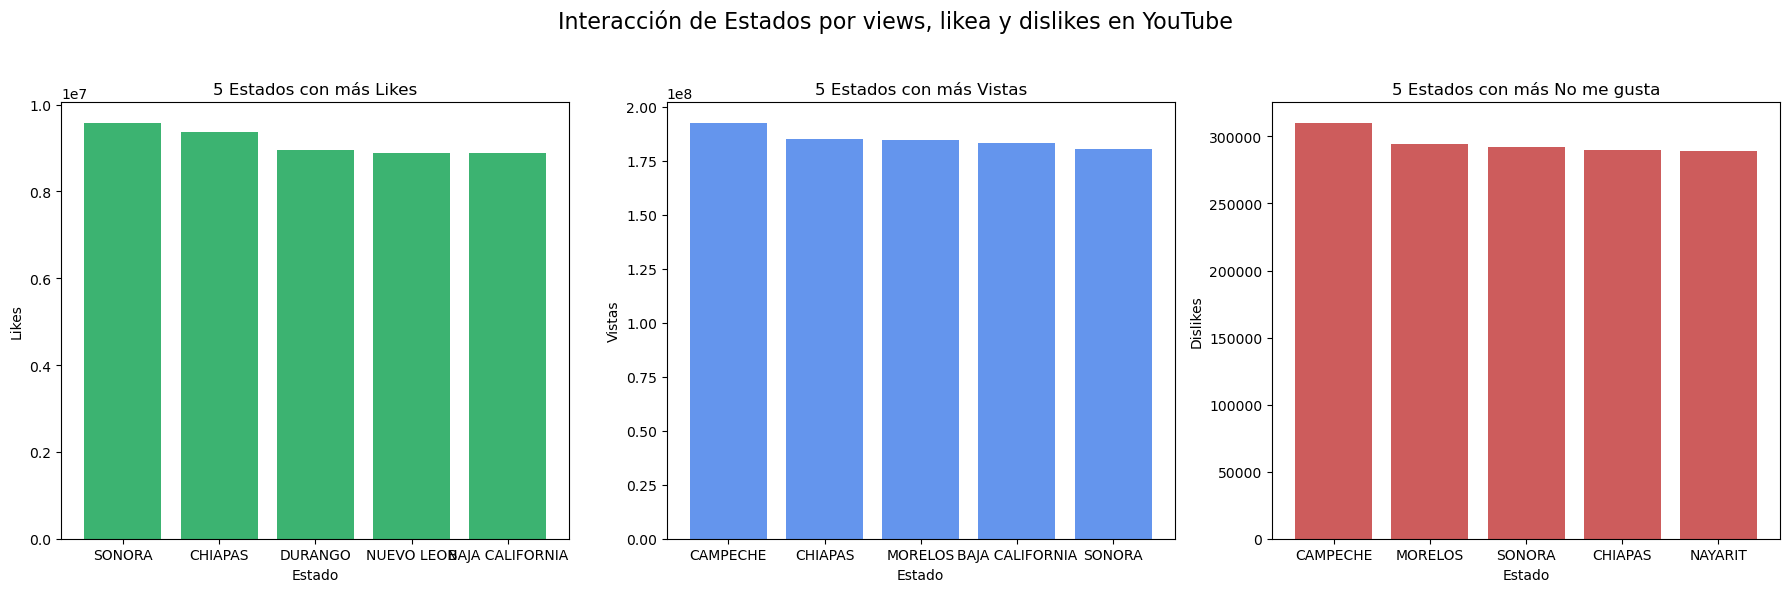

In [15]:
# Seleccionar los 5 estados con mayores valores en cada métrica
top5_likes = data_limpia.groupby('state')['likes'].sum().nlargest(5).reset_index()
top5_views = data_limpia.groupby('state')['views'].sum().nlargest(5).reset_index()
top5_dislikes = data_limpia.groupby('state')['dislikes'].sum().nlargest(5).reset_index()

# Crear figura con 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico de Likes
axs[0].bar(top5_likes['state'], top5_likes['likes'], color='mediumseagreen')
axs[0].set_title('5 Estados con más Likes')
axs[0].set_ylabel('Likes')
axs[0].set_xlabel('Estado')

# Gráfico de Views
axs[1].bar(top5_views['state'], top5_views['views'], color='cornflowerblue')
axs[1].set_title('5 Estados con más Vistas')
axs[1].set_ylabel('Vistas')
axs[1].set_xlabel('Estado')

# Gráfico de Dislikes
axs[2].bar(top5_dislikes['state'], top5_dislikes['dislikes'], color='indianred')
axs[2].set_title('5 Estados con más No me gusta')
axs[2].set_ylabel('Dislikes')
axs[2].set_xlabel('Estado')

# Ajustar presentación
plt.suptitle('Interacción de Estados por views, likea y dislikes en YouTube', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

8. ¿Los videos en tendencia son los que mayor cantidad de comentarios positivos reciben?

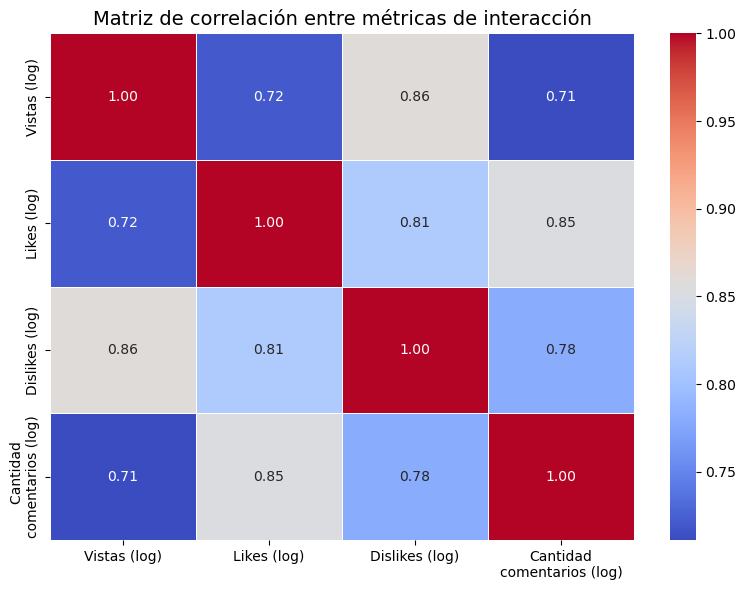

In [16]:
vars_log = ['views_log', 'likes_log', 'dislikes_log', 'comment_count_log']
corr_matrix = data_limpia[vars_log].corr()

# Rename columns and index for better labels in the heatmap
corr_matrix = corr_matrix.rename(columns={
    'views_log': 'Vistas (log)',
    'likes_log': 'Likes (log)',
    'dislikes_log': 'Dislikes (log)',
    'comment_count_log': 'Cantidad\ncomentarios (log)'
}, index={
    'views_log': 'Vistas (log)',
    'likes_log': 'Likes (log)',
    'dislikes_log': 'Dislikes (log)',
    'comment_count_log': 'Cantidad      \ncomentarios (log)'
})


# Crear heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlación entre métricas de interacción', fontsize=14)
plt.tight_layout()
plt.show()

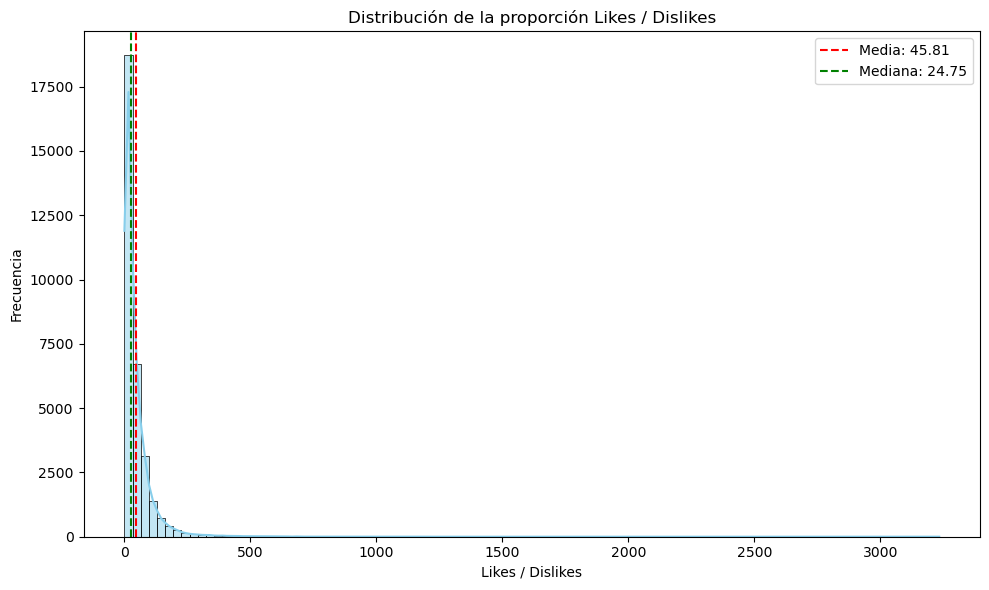

In [17]:
# Calcular el ratio likes/dislikes, evitando división por cero
data_limpia['ratio_likes_dislikes'] = data_limpia.apply(
    lambda row: row['likes'] / row['dislikes'] if row['dislikes'] != 0 else np.nan, axis=1
)

# Calcular media y mediana del ratio bruto
media_ratio = data_limpia['ratio_likes_dislikes'].mean()
mediana_ratio = data_limpia['ratio_likes_dislikes'].median()

# Histograma para visualizar la distribución del ratio
plt.figure(figsize=(10, 6))

sns.histplot(data_limpia['ratio_likes_dislikes'].dropna(), bins=100, color='skyblue', kde=True) # Using dropna() to handle NaN values
plt.axvline(media_ratio, color='red', linestyle='--', label=f'Media: {media_ratio:.2f}')
plt.axvline(mediana_ratio, color='green', linestyle='--', label=f'Mediana: {mediana_ratio:.2f}')
plt.title('Distribución de la proporción Likes / Dislikes')
plt.xlabel('Likes / Dislikes')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
data_limpia['ratio_likes_dislikes_logdiff'] = data_limpia['likes_log'] - data_limpia['dislikes_log']
correlation_views_ratio = data_limpia['views_log'].corr(data_limpia['ratio_likes_dislikes_logdiff'], method='spearman')

print(f"Correlación de Spearman entre Vistas (log) y Proporción Likes/Dislikes (log): {correlation_views_ratio:.6f}")

Correlación de Spearman entre Vistas (log) y Proporción Likes/Dislikes (log): 0.021569


9. ¿Es factible predecir el número de “Vistas” o “Me gusta” o “No me gusta”?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19112\3977931706.py:10: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



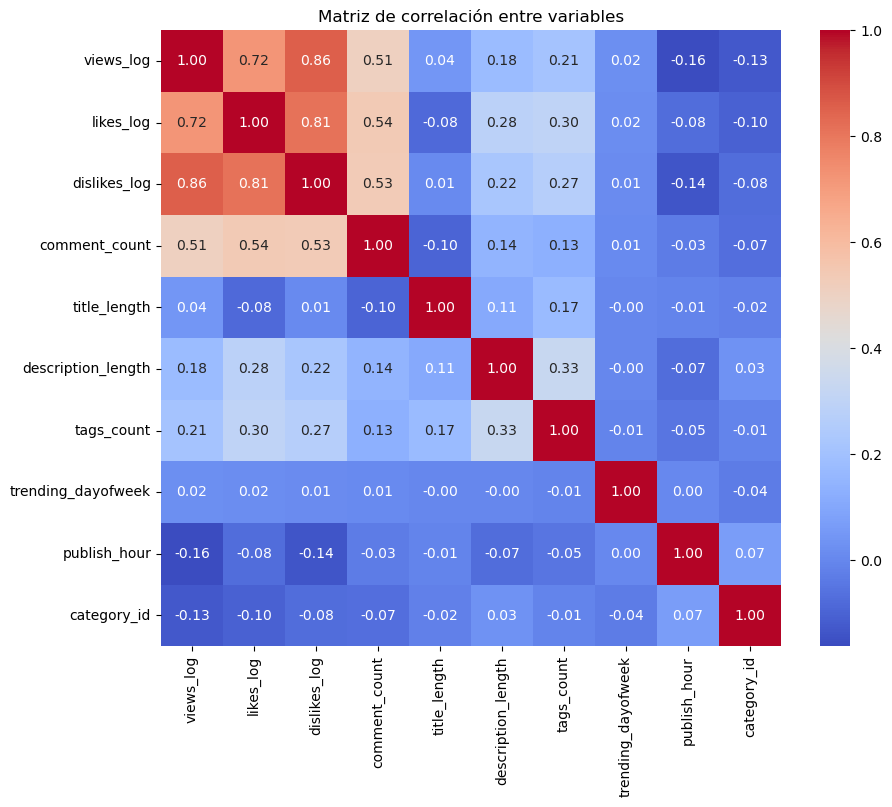

In [19]:
# Crear nuevas variables
data_limpia['title_length'] = data_limpia['title'].apply(len)
data_limpia['description_length'] = data_limpia['description'].apply(len)
data_limpia['tags_count'] = data_limpia['tags'].apply(lambda x: len(x.split('|')) if isinstance(x, str) else 0)

# Convertir trending_date a día de la semana
data_limpia['trending_dayofweek'] = pd.to_datetime(data_limpia['trending_date'], format='%y.%d.%m').dt.dayofweek

# Convertir publish_time a hora del día
data_limpia['publish_hour'] = pd.to_datetime(data_limpia['publish_time']).dt.hour

# Si tuvieras una variable "state" (por estado geográfico), asegúrate que sea numérica o la puedes excluir del heatmap

# Selección de variables para matriz de correlación
cols_correlacion = [
    'views_log', 'likes_log', 'dislikes_log', 'comment_count',
    'title_length', 'description_length', 'tags_count',
    'trending_dayofweek', 'publish_hour', 'category_id'
]

# Calcular matriz de correlación
correlation_matrix = data_limpia[cols_correlacion].corr()

# Graficar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables')
plt.show()

### Análisis de la factibilidad de predecir “Vistas” o “Me gusta” o “No me gusta”

#### Conclusión
Los resultados evidencian que las interacciones del público (likes, dislikes, comentarios) están estrechamente relacionadas entre sí y con las vistas, lo que las convierte en buenos predictores mutuos. En contraste, variables de contenido como el largo del título o la hora de publicación no muestran relación significativa con el éxito de un video. Esto sugiere que la popularidad de un video depende más de factores sociales y virales que de características formales del contenido o del canal.

#### Recomendación al negocio
- Aprovechar y estudiar las descripciones y etiquetas, pues, pese a que no tienen correlaciones muy altas, sí presentan una influencia leve, por lo que pueden usarse estratégicamente para mejorar visibilidad. 
- Usar modelos predictivos basados en interacciones anteriores (comentarios, likes) para estimar el posible éxito de futuros contenidos. 
- Explorar otras variables externas como duración del video, presencia de influencers, o campañas de promoción cruzada, que podrían explicar mejor el rendimiento.

## **MODELADO**

Como técnica de modelado, se escogió la regresión lineal. Dado que se busca generar un modelo de predicción para vistas, me gusta y no me gusta, a fin de estimar el posible éxito o tendencia de un video de YouTube en México, la regresión lineal es un modelo relativamente simple, fácil de implementar y rápido de entrenar. Estas características son útiles para procesar la gran cantidad de datos con los que cuenta el dataset. Nos permitirá identificar si las variables **predictoras seleccionadas (comment_count, description_length y tags_count)** son verdaderamente lineales o solo estiman a una aproximación.

Además, ya que se considerará variables cuantitativas, es importante asegurar una visión clara y directa del impacto de las variables seleccionadas. Un modelo de regresión lineal proporciona coeficientes para cada variable predictora que representan el efecto promedio que tiene esa variable sobre la **variable objetivo (views, likes y dislikes)**.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [21]:
X = data_limpia[['comment_count', 'description_length', 'tags_count']]
y1 = data_limpia['views_log']
y2 = data_limpia['likes_log']
y3 = data_limpia['dislikes_log']

In [22]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.3, random_state=101)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.3, random_state=101)
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y3, test_size=0.3, random_state=101)

In [23]:
lm1 = LinearRegression()
lm1.fit(X1_train,y1_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

lm3 = LinearRegression()
lm3.fit(X3_train,y3_train)

LinearRegression()

In [24]:
slope_1 = lm1.coef_
intercept_1 = lm1.intercept_

slope_2 = lm2.coef_
intercept_2 = lm2.intercept_

slope_3 = lm3.coef_
intercept_3 = lm3.intercept_

print("PARA VIEWS (CON TRANSFORMACIÓN LOGARÍTMICA)")
print("- Las pendientes 'w1' del modelo son: ", slope_1)
print("- El término independiente de la recta 'w0' es: ", intercept_1)

print("\nPARA LIKES (CON TRANSFORMACIÓN LOGARÍTMICA)")
print("- Las pendientes 'w1' del modelo son: ", slope_2)
print("- El término independiente de la recta 'w0' es: ", intercept_2)

print("\nPARA DISLIKES (CON TRANSFORMACIÓN LOGARÍTMICA)")
print("- Las pendientes 'w1' del modelo son: ", slope_3)
print("- El término independiente de la recta 'w0' es: ", intercept_3)

PARA VIEWS (CON TRANSFORMACIÓN LOGARÍTMICA)
- Las pendientes 'w1' del modelo son:  [0.00026191 0.00011812 0.01433066]
- El término independiente de la recta 'w0' es:  10.189275514522695

PARA LIKES (CON TRANSFORMACIÓN LOGARÍTMICA)
- Las pendientes 'w1' del modelo son:  [0.00036609 0.00040756 0.03124494]
- El término independiente de la recta 'w0' es:  5.911554656183152

PARA DISLIKES (CON TRANSFORMACIÓN LOGARÍTMICA)
- Las pendientes 'w1' del modelo son:  [0.00030302 0.00019966 0.02385328]
- El término independiente de la recta 'w0' es:  3.17908675320609


In [25]:
coef_df1 = pd.DataFrame(lm1.coef_,X.columns,columns=['Coeficiente'])
coef_df1

,Coeficiente
comment_count,0.000262
description_length,0.000118
tags_count,0.014331


In [26]:
coef_df2 = pd.DataFrame(lm2.coef_,X.columns,columns=['Coeficiente'])
coef_df2

,Coeficiente
comment_count,0.000366
description_length,0.000408
tags_count,0.031245


In [27]:
coef_df3 = pd.DataFrame(lm3.coef_,X.columns,columns=['Coeficiente'])
coef_df3

,Coeficiente
comment_count,0.000303
description_length,0.000200
tags_count,0.023853


|index|Coeficiente (vistas)|Coeficiente (likes)|Coeficiente (dislikes)|
|---|---|---|---|
|comment\_count|0\.000260|0\.000368|0\.000302|
|description\_length|0\.000141|0\.000440|0\.000224|
|tags\_count|0\.015379|0\.032604|0\.025164|

##### **INTERPRETACIÓN DE RESULTADOS**

**Respecto a vistas**
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en views_log, igual a **1.718 views**, está asociado con un incremento de **0.000260** en la *cantidad de comentarios*.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en views_log, igual a **1.718 views**, está asociado con un incremento de **0.000141** en la *longitud de la descripción* en palabras.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en views_log, igual a **1.718 views**, está asociado con un incremento de **0.015379** en la *cantidad de tags* incluidos.

**Respecto a me gusta**
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en likes_log, igual a **1.718 likes**, está asociado con un incremento de **0.000368** en la *cantidad de comentarios*.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en likes_log, igual a **1.718 likes**, está asociado con un incremento de **0.000440** en la *longitud de la descripción* en palabras.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en likes_log, igual a **1.718 likes**, está asociado con un incremento de **0.032604** en la *cantidad de tags* incluidos.

**Respecto a no me gusta**
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en dislikes_log, igual a **1.718 dislikes**, está asociado con un incremento de **0.000302** en la *cantidad de comentarios*.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en dislikes_log, igual a **1.718 dislikes**, está asociado con un incremento de **0.000224** en la *longitud de la descripción* en palabras.
- Manteniendo todas las demás características fijas, un aumento de **1 unidad** en dislikes_log, igual a **1.718 dislikes**, está asociado con un incremento de **0.025164** en la *cantidad de tags* incluidos.

In [28]:
views_log_pred = lm1.predict(X1_test)
likes_log_pred = lm2.predict(X2_test)
dislikes_log_pred = lm3.predict(X3_test)

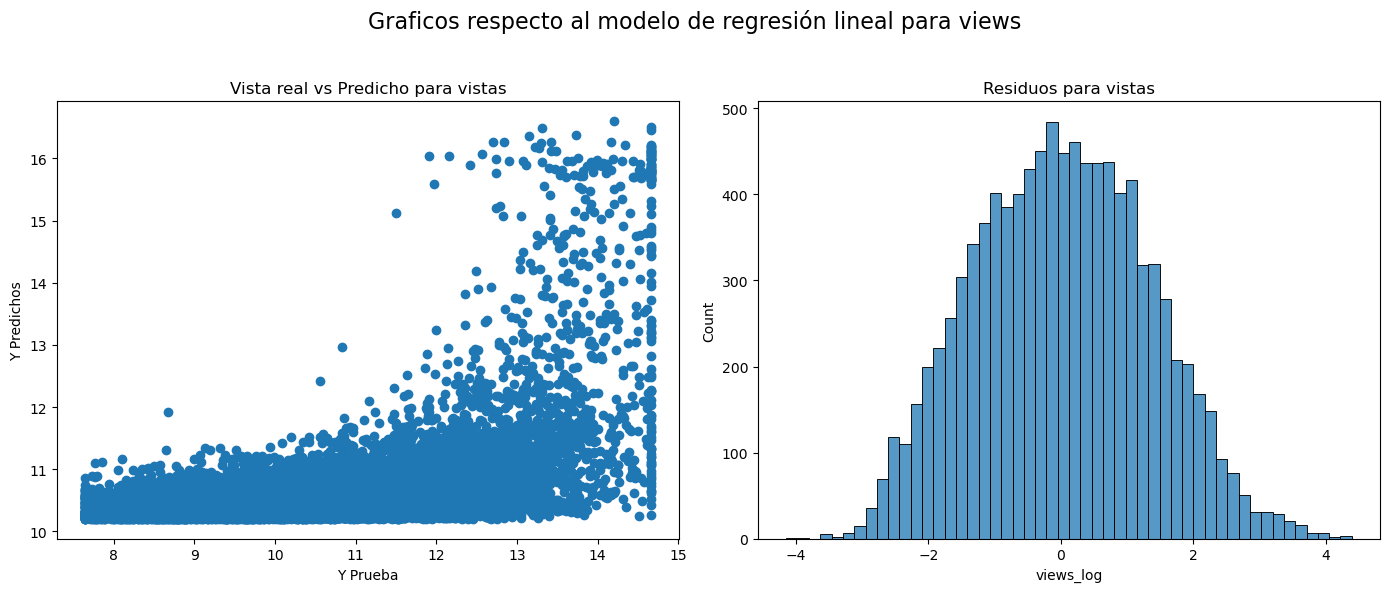

In [29]:
# Crear figura con 2 subplots para views
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de vista real
axs[0].scatter(y1_test,views_log_pred)
axs[0].set_xlabel('Y Prueba')
axs[0].set_ylabel('Y Predichos')
axs[0].set_title('Vista real vs Predicho para vistas')

# Gráfico de residuos
sns.histplot((y1_test-views_log_pred),bins=50, ax=axs[1])
axs[1].set_title('Residuos para vistas')


# Ajustar presentación
plt.suptitle('Graficos respecto al modelo de regresión lineal para views', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

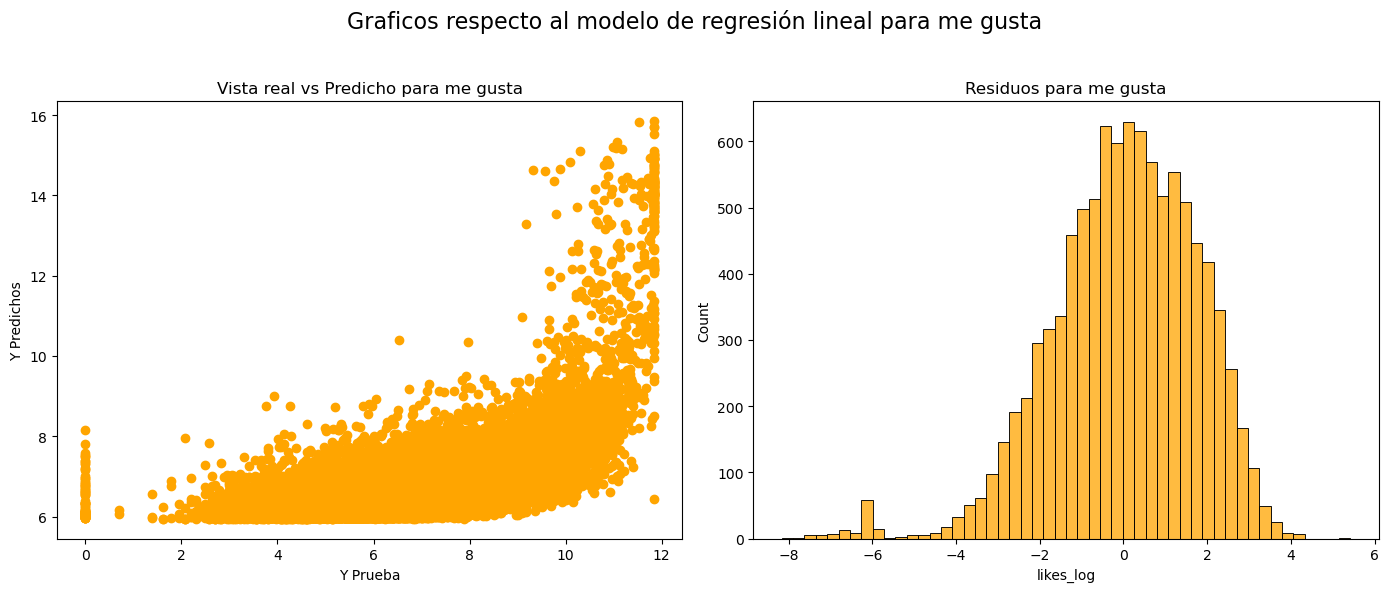

In [30]:
# Crear figura con 2 subplots para likes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de vista real
axs[0].scatter(y2_test,likes_log_pred,color='orange')
axs[0].set_xlabel('Y Prueba')
axs[0].set_ylabel('Y Predichos')
axs[0].set_title('Vista real vs Predicho para me gusta')

# Gráfico de residuos
sns.histplot((y2_test-likes_log_pred),bins=50, ax=axs[1],color='orange')
axs[1].set_title('Residuos para me gusta')


# Ajustar presentación
plt.suptitle('Graficos respecto al modelo de regresión lineal para me gusta', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

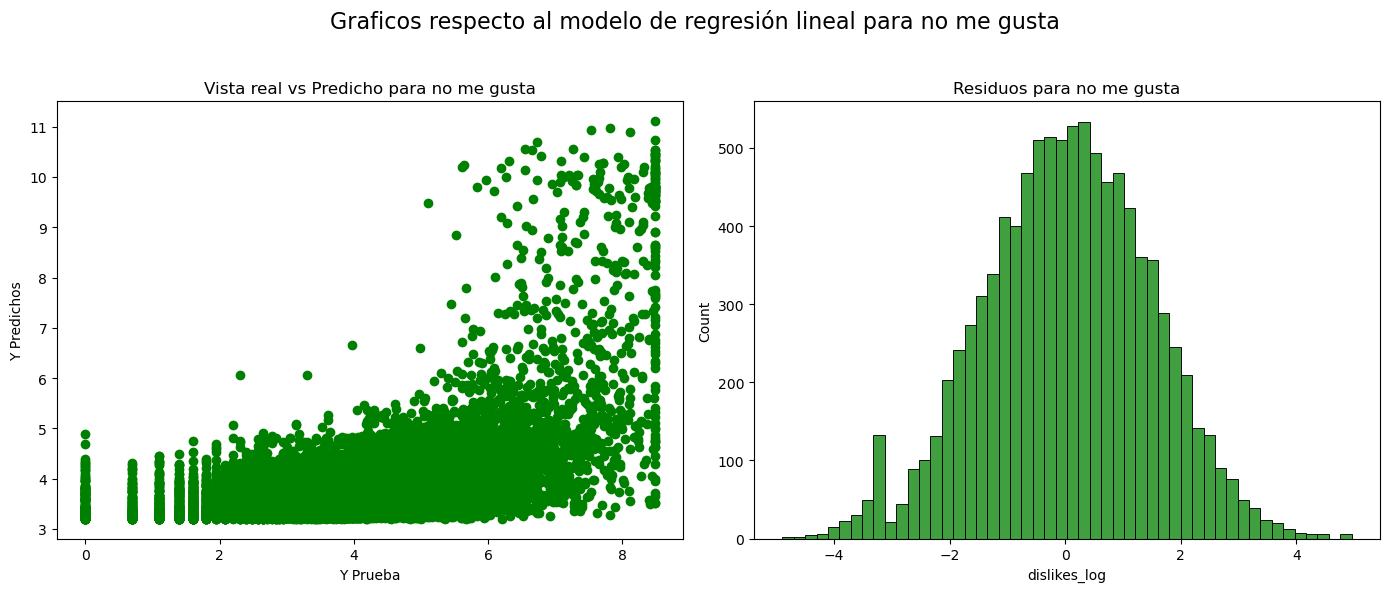

In [31]:
# Crear figura con 2 subplots para likes
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de vista real
axs[0].scatter(y3_test,dislikes_log_pred,color='green')
axs[0].set_xlabel('Y Prueba')
axs[0].set_ylabel('Y Predichos')
axs[0].set_title('Vista real vs Predicho para no me gusta')

# Gráfico de residuos
sns.histplot((y3_test-dislikes_log_pred),bins=50, ax=axs[1],color='green')
axs[1].set_title('Residuos para no me gusta')


# Ajustar presentación
plt.suptitle('Graficos respecto al modelo de regresión lineal para no me gusta', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()